In [33]:
%matplotlib inline
from pathlib import Path

import cv2
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import MiniBatchKMeans

import img_qc.img_qc as img_qc

In [65]:
def find_contours(image_binarized):
        
    # find the contours in the thresholded image keeping the external one
    _, contours, hierarchy = cv2.findContours(image_binarized, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
    return contours

def find_external_rectangle(contours, minimum_area = 500000):
    
    # loop over the contours individually
    for (i, contour) in enumerate(contours):
    # if the contour is not sufficiently large, ignore it
        if cv2.contourArea(contour) < 500000:  # use 20000 for scrapbook pages
            continue
            
        # compute the rotated bounding box of the contour
        box = cv2.minAreaRect(contour)
        box = cv2.boxPoints(box)
        box = np.int0(box)
        
        # re-order the points in tl, tr, br, bl order
        rect = img_qc.order_points(box)
        
        # find the points and angle for minAreaRectangle
        (x, y), (w, h), theta = cv2.minAreaRect(contour)
            
        # the `cv2.minAreaRect` function returns values in the
        # range [-90, 0); as the rectangle rotates clockwise the
        # returned angle trends to 0 -- in this special case we
        # need to add 90 degrees to the angle
        if theta < -45:
            angle = -(90 + theta)
 
        # otherwise, just take the inverse of the angle to make
        # it positive
        else:
            angle = -theta
            
    return rect, x, y, angle

In [58]:
class NegativeScan:
    
    def __init__(self, image_path):
        self.image_path = Path(image_path)
        
        
    def blur_image(self):
    
        image_cv2 = cv2.imread(str(self.image_path))
        if len(image_cv2.shape) > 2:  # NOT grayscale
            image_cv2 = cv2.cvtColor(image_cv2, cv2.COLOR_BGR2GRAY)
        image_blurred = cv2.bilateralFilter(image_cv2, 21, 21, 21)
    
        return image_blurred
    
    
    def quantize(self, number_of_clusters = 5):
        
        image_blurred = self.blur_image()
    
        if len(image_blurred.shape) < 3:  # image grayscale
            image_blurred = cv2.cvtColor(image_blurred, cv2.COLOR_GRAY2BGR)
        
        image_blurred = cv2.cvtColor(image_blurred, cv2.COLOR_BGR2LAB)
        h, w = image_blurred.shape[:2]
    
        reshaped_image = image_blurred.reshape((image_blurred.shape[0] * image_blurred.shape[1], 3))
    
        # apply k-means using the specified number of clusters and
        # then create the quantizedized reshaped based on the predictions
        clt = MiniBatchKMeans(n_clusters = number_of_clusters)
        labels = clt.fit_predict(reshaped_image)
        quantized = clt.cluster_centers_.astype("uint8")[labels]
 
        # reshape the feature vectors to reshapeds
        quantized = quantized.reshape((h, w, 3))
 
        # convert from L*a*b* to RGB
        quantized = cv2.cvtColor(quantized, cv2.COLOR_LAB2BGR)
    
        return quantized
    
    
    def equalize(self):
        quantized = self.quantize()
        image_gray = cv2.cvtColor(quantized, cv2.COLOR_BGR2GRAY)
        image_equalized = cv2.equalizeHist(image_gray)
        return image_equalized
    
    
    def threshold_kmeans(self):
    
        equalized = self.equalize()

        # invert image
        inverted = np.invert(equalized)
    
        # manual threshold value so EVERYTHING 1-255 -> 255
        _, image_binarized = cv2.threshold(inverted, 1, 255, cv2.THRESH_BINARY)
    
        return image_binarized

In [59]:
neg_scan = NegativeScan('/Users/jeremy/Pictures/bennett_pack-film/Output/_autocrop_jpg/MS3892-B2-S11-F35_002.jpg')

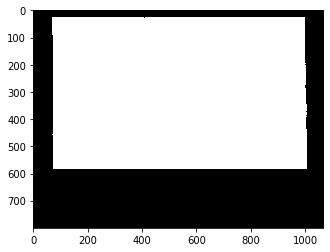

In [60]:
threshold = neg_scan.threshold_kmeans()
plt.imshow(threshold, cmap='gray')

In [61]:
contours = find_contours(threshold)
len(contours)

3

In [64]:
find_external_rectangle(contours)

(array([[  69.,   26.],
        [1002.,   23.],
        [1003.,  582.],
        [  71.,  584.]], dtype=float32),
 536.7015380859375,
 304.31390380859375,
 0.12442060559988022)